## Initial Setup

In [1]:
from pyspark.sql import SparkSession

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1726056848309_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Basics").getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Run this everytime you create a new spark instance. 

spark.sparkContext.install_pypi_package("plotly")
spark.sparkContext.install_pypi_package("pandas")
spark.sparkContext.install_pypi_package("numpy")
spark.sparkContext.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1726056848309_0002/container_1726056848309_0002_01_000001/tmp/spark-386b872c-b4b7-4973-8579-d6e4df3d73c9
    Can't uninstall 'python-dateutil'. No files were found to uninstall.




ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.



In [5]:
from pyspark.sql import functions as F
from pyspark.ml.feature import Bucketizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import for typecasting columns
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType,StringType
from pyspark.sql.types import ArrayType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Defining Custom Functions 

In [6]:
def get_quantiles(df, col_name, quantiles_list = [0.01, 0.25, 0.5, 0.75, 0.99]):
    """
    Takes a numerical column and returns column values at requested quantiles

    Inputs 
    Argument 1: Dataframe
    Argument 2: Name of the column
    Argument 3: A list of quantiles you want to find. Default value [0.01, 0.25, 0.5, 0.75, 0.99]

    Output 
    Returns a dictionary with quantiles as keys and column quantile values as values 
    """
    # Get min, max and quantile values for given column
    min_val = df.agg(F.min(col_name)).first()[0]
    max_val = df.agg(F.max(col_name)).first()[0]
    quantiles_vals = df.approxQuantile(col_name,
                                       quantiles_list,
                                       0)
  
    # Store min, quantiles and max in output dict, sequentially
    quantiles_dict = {0.0:min_val}
    quantiles_dict.update(dict(zip(quantiles_list, quantiles_vals)))
    quantiles_dict.update({1.0:max_val})
    return(quantiles_dict)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:

def plot_bucketwise_statistics (summary, bucketizer):
    """
    Takes in a dataframe and a bucketizer object and plots the summary statistics for each bucket in the dataframe. 
  
    Inputs
    Argument 1: Pandas dataframe obtained from bucket_col_print_summary function 
    Argument 2: Bucketizer object obtained from bucket_col_print_summary function
  
    Output
    Displays a plot of bucketwise average ratings nunber of ratings of a parameter.   
    """
    # Creating bucket labels from splits
    classlist = bucketizer.getSplits()
    number_of_classes = len(classlist) - 1

    class_labels = []
    hover_labels = []
    for i in range (number_of_classes):
        hover_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) +" (Bucket name: "+ str(int(i)) +")"  )
        class_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) )
  
    summary["Scaled_number"] = (summary["n_ratings"]-summary["n_ratings"].min())/(summary["n_ratings"].max()-summary["n_ratings"].min()) + 1.5
    summary['Bucket_Names'] = class_labels
  
    # making plot
    x = summary["Bucket_Names"]
    y1 = summary["avg_rating"]
    y2 = summary["n_ratings"]
    err = summary["stddev_rating"]  

    # Plot scatter here
    plt.rcParams["figure.figsize"] = [summary.shape[0]+2, 6.0]
    plt.rcParams["figure.autolayout"] = True
    fig, ax1 = plt.subplots()

    bar = ax1.bar(x, y1, color = "#262261")
    ax1.errorbar(x, y1, yerr=err, fmt="o", color="#EE4036")
    ax1.set(ylim=(0, 7))
  
    #ax1.bar_label(bar , fmt='%.2f', label_type='edge')  
    def barlabel(x_list,y_list):
        for i in range(len(x_list)):
            ax1.text(i,y_list[i] + 0.2,y_list[i], ha = 'center',
  			         fontdict=dict(size=10),
  			         bbox=dict(facecolor='#262261', alpha=0.2)         
  			        )
    barlabel(summary["Bucket_Names"].tolist() ,summary["avg_rating"].round(2).tolist())
  
    ax2 = ax1.twinx()
    ax2.scatter(x, y2, s=summary["Scaled_number"]*500, c = '#FAAF40')  
    ax2.set(ylim=(0, summary["n_ratings"].max()*1.15))
    def scatterlabel(x_list,y_list):
  	    for i in range(len(x_list)):
  		    ax2.text(i,y_list[i] + 15000,y_list[i], ha = 'center',
  					 fontdict=dict(size=10),
                     bbox=dict(facecolor='#FAAF40', alpha=0.5)
  					)
    scatterlabel(summary["Bucket_Names"].tolist() ,summary["n_ratings"].tolist())
  
    # giving labels to the axises
    ax1.set_xlabel(bucketizer.getOutputCol(), fontdict=dict(size=14)) 
    ax1.set_ylabel("Average Ratings",fontdict=dict(size=14))
  
    # secondary y-axis label
    ax2.set_ylabel('Number of Ratings',fontdict=dict(size=14))
  
    #plot Title
    plt.title('Bucketwise average ratings and number of ratings for \n'+bucketizer.getInputCol(), 
              fontdict=dict(size=14))  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def bucket_col_print_summary(df, splits, inputCol, outputCol):
    """
    Given a numerical column in a data frame, adds a bucketized version of the column to the data frame, according to splits provided.
    Also prints a summary of ratings seen in each bucket made.

    Inputs 
    Argument 1: Data Frame 
    Argument 2: Values at which the column will be split
    Argument 3: Name of the input column (numerical column)
    Argument 4: Name of the output column (bucketized numerical column)

    Output: 
    1) New dataframe with the output column added
    2) Bucketizer object trained from the input column 
    3) Pandas dataframe with summary statistics for ratings seen in buckets of the output column
    Also plots summary statistics for ratings seen in buckets of the output column
    """

    # Dropping bucket if it already exists
    if outputCol in df.columns:
        df = df.drop(outputCol)

    # Training bucketizer
    bucketizer = Bucketizer(splits = splits,
                            inputCol  = inputCol,
                            outputCol = outputCol)
    
    df = bucketizer.setHandleInvalid("keep").transform(df)

    # Printing meta information on buckets created
    print("Added bucketized column {}".format(outputCol))
    print("")
    print("Bucketing done for split definition: {}".format(splits))
    print("")  
    print("Printing summary statistics for ratings in buckets below:")

    # Creating a summary statistics dataframe and passing it to the plotting function
    summary =  (df
                .groupBy(outputCol)
                .agg(F.avg('rating').alias('avg_rating'),
                     F.stddev('rating').alias('stddev_rating'),
                     F.count('rating').alias('n_ratings'))
                .sort(outputCol)
                .toPandas())
  
    plot_bucketwise_statistics(summary,bucketizer)
  
    return df, bucketizer, summary

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def get_column_distribution_summary(df, col_name):
    """
    Takes a column in a data frame and prints the summary statistics (average, standard deviation, count and distinct count) for all unique values in that column.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Name of the column
  
    Output
    Returns nothing 
    Prints a Dataframe with summary statistics
    """
    print(df
          .groupBy(col_name)
          .agg(F.avg('rating').alias('avg_rating'),
               F.stddev('rating').alias('stddev_rating'),
               F.count('rating').alias('n_ratings'),
               F.countDistinct('id').alias('n_recipes'))
          .sort(F.col(col_name).asc())
          .show(50))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def get_n_items_satisfying_condition (df, condition, aggregation_level = "recipe"):
    """
    Given a condition, find the number of recipes / reviews that match the condition.
    Also calculates the percentage of such recipes / reviews as a percentage of all recipes / reviews.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Logical expression describing a condition, string type. eg: "minutes == 0"
    Argument 3: Aggregation level for determining "items", either  "recipe" or "review". Default value == "recipe"
  
    Output: Returns no object.
    Prints the following:
    1) Number of recipes / reviews that satisfy the condition
    2) Total number of recipes / reviews in the dataframe
    3) Percentage of recipes / reviews that satisfy the condition
    """
    # Find out num rows satisfying the condition
    if aggregation_level == "recipe": 
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id"))).first()[0]
      
        n_rows_total = (df.agg(F.countDistinct("id"))).first()[0]
    if aggregation_level == "review":
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id","user_id"))).first()[0]
        n_rows_total = (df.agg(F.countDistinct("id","user_id"))).first()[0]
  
    # Find out % rows satisfying the conditon and print a properly formatted output
    perc_rows = round(number_of_rows_satisfying_condition * 100/ n_rows_total, 2)
    print('Condition String                   : "{}"'.format(condition))
    print("Num {}s Satisfying Condition   : {} [{}%]".format(aggregation_level.title(), number_of_rows_satisfying_condition, perc_rows))
    print("Total Num {}s                  : {}".format(aggregation_level.title(), n_rows_total))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Read the data

- Read ```interaction_level_df_processed```

In [11]:
interaction_level_df = spark.read.parquet("s3://upgradfoodassignment/interaction_level_df_processed.parquet", header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert interaction_level_df.count() == 1132367, "There is a mistake in reading the data."
assert len(interaction_level_df.columns) == 33, "There is a mistake in reading the data."

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
interaction_level_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+------+--------------------+-----------+--------------------+---+-------+--------------+----------+--------------------+--------------------+-------+--------------------+-----------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+-----------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+
|user_id|recipe_id|rating|              review|review_date|                name| id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|carbohydrates_PDV|total_fat_per_100_cal|sugar_per_100_cal|sodium_per_100_cal|protein_per_100_cal|saturated_fat_per_1

## Bucketing and Cleaning Numerical Features

#### **1. `years_since_submission_on_review_date`** 
[Review Time Since Submission]
- Recipes more than 6 years old are rated low

In [14]:
get_quantiles(df = interaction_level_df,
              col_name = "years_since_submission_on_review_date")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: -4.833333333333333, 0.01: 0.005376344166666667, 0.25: 0.8602150541666668, 0.5: 2.9489247308333333, 0.75: 5.844086021666667, 0.99: 14.626344085833333, 1.0: 19.284946236666666}

In [15]:
get_n_items_satisfying_condition(df = interaction_level_df,
                                 condition= 'years_since_submission_on_review_date < 0',
                                 aggregation_level= "review")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Condition String                   : "years_since_submission_on_review_date < 0"
Num Reviews Satisfying Condition   : 1246 [0.11%]
Total Num Reviews                  : 1132367

In [16]:
# Only keep interactions with review dates >= recipe submission date

interaction_level_df = (interaction_level_df
                        .filter('years_since_submission_on_review_date >= 0'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
splits = [ 0, 1, 3, 6, float('Inf')]
inputCol  = "years_since_submission_on_review_date"
outputCol = "years_since_submission_on_review_date_bucket"

(interaction_level_df, submission_time_bucketizer, submission_time_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Added bucketized column years_since_submission_on_review_date_bucket

Bucketing done for split definition: [0, 1, 3, 6, inf]

Printing summary statistics for ratings in buckets below:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

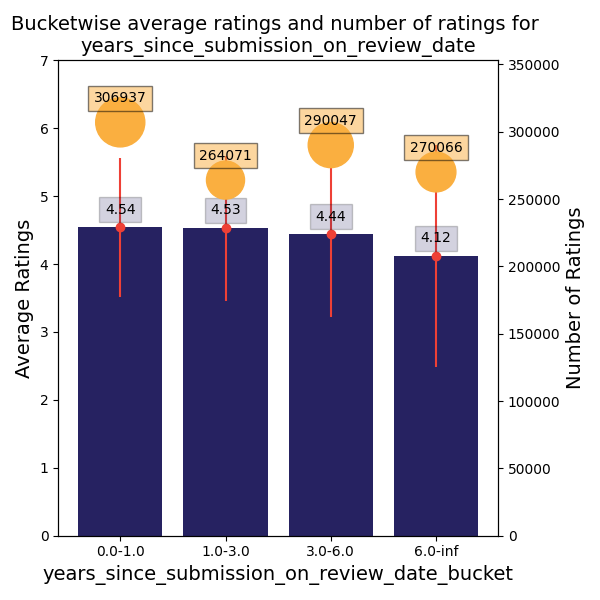

In [18]:
%matplot plt

#### **2. `minutes`** 

[prep time]
- Somewhat relevant
- Low prep time is preferred

In [19]:
get_quantiles(df = interaction_level_df,
              col_name = "minutes",
              quantiles_list=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 0, 0.01: 2.0, 0.05: 5.0, 0.25: 20.0, 0.5: 40.0, 0.75: 70.0, 0.95: 310.0, 0.99: 930.0, 1.0: 2147483647}

In [20]:
# Capping prep time at 930 minutes

interaction_level_df = (interaction_level_df
                        .withColumn("minutes",
                                    F.when(interaction_level_df["minutes"] > 930, 930)
                                     .otherwise(interaction_level_df["minutes"])))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# investigating recipes with minutes = 0 -> Look at n_steps for such recipes.

get_column_distribution_summary(df = (interaction_level_df
                                      .filter('minutes == 0')
                                      .withColumn('n_steps_modified', (F.when(interaction_level_df['n_steps'] >= 10, ">= 10")
                                                                        .otherwise(F.lpad(interaction_level_df['n_steps'],2,"0"))))),
                                col_name = 'n_steps_modified')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------------------+------------------+---------+---------+
|n_steps_modified|        avg_rating|     stddev_rating|n_ratings|n_recipes|
+----------------+------------------+------------------+---------+---------+
|              01|              4.24|1.0908712114635715|       25|       12|
|              02|4.4423076923076925|  1.08678668673504|      104|       28|
|              03| 3.989130434782609|1.5750414356065066|      184|       44|
|              04|  4.30635838150289|1.3867374413641125|      173|       57|
|              05| 4.231788079470198| 1.356386192466306|      302|       90|
|              06|       4.470703125|1.1463893346523668|      512|      102|
|              07|4.3447432762836184|1.2875641979464003|      409|       92|
|              08| 4.381995133819951| 1.277408546667124|      411|       92|
|              09| 4.076190476190476|1.5270088873176948|      315|       86|
|           >= 10| 4.240963855421687|1.3768155493871745|     2075|      491|

In [22]:
# let's look at some examples with 1 step only to see if this makes sense

interaction_level_df.filter('minutes == 0 and n_steps == 1').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+------+--------------------+-----------+--------------------+------+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+------------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+--------------------------------------------+
|user_id|recipe_id|rating|              review|review_date|                name|    id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|carbohydrates_PDV|total_fat_per_100_cal| sugar

In [23]:
get_n_items_satisfying_condition(df = interaction_level_df,
                                 condition = 'minutes == 0',
                                 aggregation_level = "recipe")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Condition String                   : "minutes == 0"
Num Recipes Satisfying Condition   : 1094 [0.47%]
Total Num Recipes                  : 231501

In [24]:
# Remove recipes with cook time zero

interaction_level_df = interaction_level_df.filter("minutes > 0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
splits = [0, 5, 15, 30, 60, 300, 900, float('Inf')]
inputCol  = "minutes"
outputCol = "prep_time_bucket"

(interaction_level_df, prep_time_bucketizer, prep_time_summary_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Added bucketized column prep_time_bucket

Bucketing done for split definition: [0, 5, 15, 30, 60, 300, 900, inf]

Printing summary statistics for ratings in buckets below:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

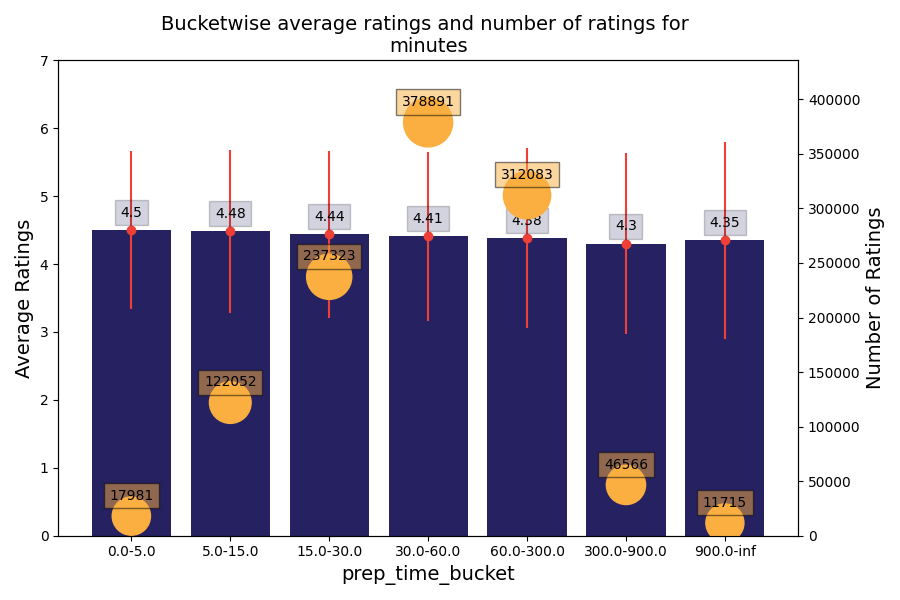

In [26]:
%matplot plt

**3. `n_steps`**

- Clearly relevant
- Recipes with less than 2 steps are rated high
- Recipes with more than 29 steps are rated very low

In [27]:
get_quantiles(df = interaction_level_df,
              col_name = "n_steps")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 0, 0.01: 2.0, 0.25: 6.0, 0.5: 8.0, 0.75: 12.0, 0.99: 29.0, 1.0: 145}

In [28]:
interaction_level_df.filter('n_steps == 0').show(5, truncate = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------------+------+-------+--------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
get_n_items_satisfying_condition(df = interaction_level_df,
                                 condition = 'n_steps == 0',
                                 aggregation_level = "recipe")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Condition String                   : "n_steps == 0"
Num Recipes Satisfying Condition   : 1 [0.0%]
Total Num Recipes                  : 230407

In [30]:
# Remove recipes with n_steps zero

interaction_level_df = interaction_level_df.filter("n_steps > 0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
splits = [0, 2, 6, 8, 12, 29, float('Inf')]
inputCol  = "n_steps"
outputCol = "n_steps_bucket"

(interaction_level_df, n_steps_bucketizer, n_steps_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Added bucketized column n_steps_bucket

Bucketing done for split definition: [0, 2, 6, 8, 12, 29, inf]

Printing summary statistics for ratings in buckets below:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

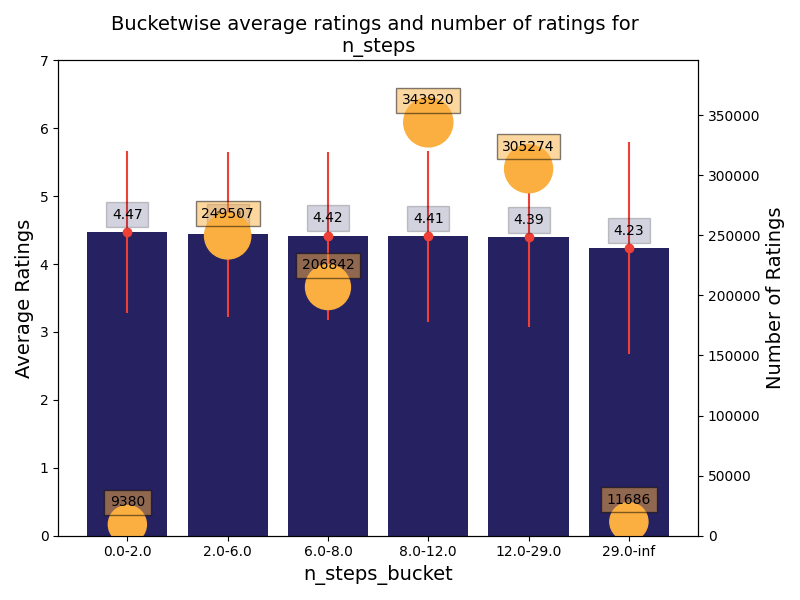

In [32]:
%matplot plt

**4. `n_ingredients`**
- Not relevant

In [33]:
get_quantiles(df = interaction_level_df,
              col_name = "n_ingredients")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 1, 0.01: 2.0, 0.25: 6.0, 0.5: 9.0, 0.75: 11.0, 0.99: 20.0, 1.0: 43}

In [34]:
splits = [0, 6, 9, 11, float('Inf')]
inputCol  = "n_ingredients"
outputCol = "n_ingredients_bucket"

(interaction_level_df, n_ingredients_bucketizer, n_ingredients_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Added bucketized column n_ingredients_bucket

Bucketing done for split definition: [0, 6, 9, 11, inf]

Printing summary statistics for ratings in buckets below:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

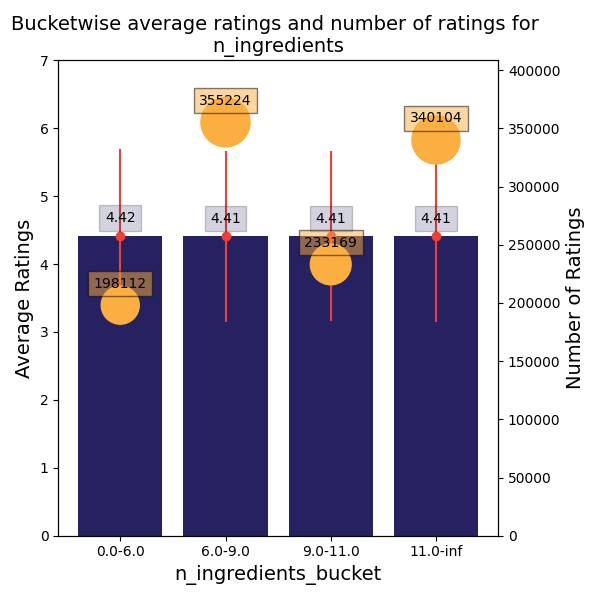

In [35]:
%matplot plt

**5. `nutrition` columns**

- `calories` - Calories per serving seems irrelevant
- `fat (per 100 cal)` - Calories per serving seems irrelevant
- `sugar (per 100 cal)` - Calories per serving seems irrelevant
- `sodium (per 100 cal)` - Calories per serving seems irrelevant
- `protein (per 100 cal)` - Calories per serving seems irrelevant
- `sat. fat (per 100 cal)` - Calories per serving seems irrelevant
- `carbs (per 100 cal)` - Calories per serving seems irrelevant

In [36]:
interaction_level_df.columns 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['user_id', 'recipe_id', 'rating', 'review', 'review_date', 'name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'calories', 'total_fat_PDV', 'sugar_PDV', 'sodium_PDV', 'protein_PDV', 'saturated_fat_PDV', 'carbohydrates_PDV', 'total_fat_per_100_cal', 'sugar_per_100_cal', 'sodium_per_100_cal', 'protein_per_100_cal', 'saturated_fat_per_100_cal', 'carbohydrates_per_100_cal', 'days_since_submission_on_review_date', 'months_since_submission_on_review_date', 'years_since_submission_on_review_date', 'years_since_submission_on_review_date_bucket', 'prep_time_bucket', 'n_steps_bucket', 'n_ingredients_bucket']

In [37]:
nutrition_cols = ['calories', 
                  'total_fat_PDV', 
                  'sugar_PDV', 
                  'sodium_PDV', 
                  'protein_PDV', 
                  'saturated_fat_PDV', 
                  'carbohydrates_PDV', 
                  'total_fat_per_100_cal', 
                  'sugar_per_100_cal', 
                  'sodium_per_100_cal', 
                  'protein_per_100_cal', 
                  'saturated_fat_per_100_cal', 
                  'carbohydrates_per_100_cal']

quantiles_list = [0.00, 0.05, 0.25, 0.5, 0.75, 0.95, 1.00]
nutrition_col_quantiles = pd.DataFrame(index = quantiles_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
for col in nutrition_cols:
    nutrition_col_quantiles[col] = (get_quantiles(df = interaction_level_df,
                                                col_name = col,
                                                quantiles_list=quantiles_list)
                                  .values())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
nutrition_col_quantile_summary = pd.DataFrame(index = ["0.00-0.25", "0.25-0.50", "0.50-0.75", "0.75-0.95", "0.95 - 1.00"])

for col in nutrition_cols:
    splits = ([0]
            + list(nutrition_col_quantiles.loc[[0.25, 0.5, 0.75, 0.95], col].round())
            + [float('Inf')])
    inputCol  = col
    outputCol = col+"_bucket"

    if outputCol in interaction_level_df.columns:
        interaction_level_df = interaction_level_df.drop(outputCol)

  # Training bucketizer
    bucketizer = Bucketizer(splits = splits,
                          inputCol  = inputCol,
                          outputCol = outputCol)
  
    interaction_level_df = bucketizer.setHandleInvalid("keep").transform(interaction_level_df)
  
    nutrition_col_quantile_summary.loc[:, col] = (interaction_level_df
                                                .groupBy(outputCol)
                                                .agg(F.avg('rating').alias('avg_rating'))
                                                .sort(outputCol)
                                                .select('avg_rating').toPandas().values)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# set the max columns to none
pd.set_option('display.max_columns', None)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
nutrition_col_quantile_summary

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             calories  total_fat_PDV  sugar_PDV  sodium_PDV  protein_PDV  \
0.00-0.25    4.416167       4.393560   4.416368    4.423843     4.422679   
0.25-0.50    4.428239       4.420946   4.434610    4.408631     4.419234   
0.50-0.75    4.418471       4.427758   4.403005    4.422298     4.410517   
0.75-0.95    4.393681       4.411867   4.406985    4.397199     4.399930   
0.95 - 1.00  4.342026       4.371152   4.332979    4.373164     4.372771   

             saturated_fat_PDV  carbohydrates_PDV  total_fat_per_100_cal  \
0.00-0.25             4.396849           4.439453               4.385130   
0.25-0.50             4.422079           4.421594               4.396544   
0.50-0.75             4.423550           4.417625               4.415027   
0.75-0.95             4.414637           4.382006               4.438629   
0.95 - 1.00           4.351969           4.324922               4.476848   

             sugar_per_100_cal  sodium_per_100_cal  protein_per_100_cal  \
0.00-0.25  

In [42]:
## Writing the modified data to S3 

interaction_level_df.write.mode('overwrite').parquet("s3a://upgradfoodassignment/interaction_level_df_postEDA.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…